# Data Processing for Household income to Restaurant cost. 

In [100]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns

### Clean up Data

In [102]:
# Read the CSV file into a DataFrame
df = pd.read_csv("restaurants_data/combined_data.csv")

# Clean up the 'transactions' column
df['transactions'] = df['transactions'].apply(lambda x: ast.literal_eval(x))

# Clean up the 'is_closed' column
df['is_closed'] = df['is_closed'].astype(bool)

# Convert the 'location' column from string to dictionary
df['location'] = df['location'].apply(lambda x: ast.literal_eval(x))

# Extract the relevant information from the 'location' dictionary
df['address1'] = df['location'].apply(lambda x: x.get('address1'))
df['address2'] = df['location'].apply(lambda x: x.get('address2'))
df['address3'] = df['location'].apply(lambda x: x.get('address3'))
df['city'] = df['location'].apply(lambda x: x.get('city'))
df['zip_code'] = df['location'].apply(lambda x: x.get('zip_code'))
df['country'] = df['location'].apply(lambda x: x.get('country'))
df['state'] = df['location'].apply(lambda x: x.get('state'))
df['display_address'] = df['location'].apply(lambda x: ', '.join(x.get('display_address')))

# Drop the original 'location' column
df.drop(columns=['location'], inplace=True)

# Convert the 'categories' column from string to list of dictionaries
df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x))

# Extract alias and title for each category and create new columns
for i in range(len(df)):
    category_list = df.at[i, 'categories']
    for j, category in enumerate(category_list):
        df.at[i, f'category_{j+1}_type'] = category['alias']
        df.at[i, f'category_{j+1}_title'] = category['title']

# Drop the original 'categories' column
df.drop(columns=['categories'], inplace=True)

# Remove rows where the price is empty
df = df.dropna(subset=['price'])

# Specify the output filename
output_filename = "data/cleaned_data.csv"

# Save the cleaned DataFrame to a new CSV file
df.to_csv(output_filename, index=False)

print("Cleaned data saved to", output_filename)

Cleaned data saved to data/cleaned_data.csv


In [103]:
showcsv = pd.read_csv("data/cleaned_data.csv")
showcsv.head()

,id,name,price,rating,review_count,url,transactions,is_closed,address1,address2,...,zip_code,country,state,display_address,category_1_type,category_1_title,category_2_type,category_2_title,category_3_type,category_3_title
0,U9D0vqEP4QrJfJYs8mr3DA,Oiistar,$$,4.2,1142,https://www.yelp.com/biz/oiistar-chicago?adjus...,[],False,1385 N Milwaukee Ave,NaN,...,60622,US,IL,"1385 N Milwaukee Ave, Chicago, IL 60622",asianfusion,Asian Fusion,ramen,Ramen,NaN,NaN
1,o6O9gCksHBGG7-m0PwRH_g,Urbanbelly,$$,4.0,319,https://www.yelp.com/biz/urbanbelly-chicago-26...,"['delivery', 'pickup']",False,1542 N Damen Ave,NaN,...,60622,US,IL,"1542 N Damen Ave, Chicago, IL 60622",asianfusion,Asian Fusion,ramen,Ramen,NaN,NaN
2,bZ7lvi5_BQ6UKK10OKPV7Q,Sushi Taku,$$,4.3,1124,https://www.yelp.com/biz/sushi-taku-chicago-2?...,"['delivery', 'pickup']",False,1904 W Division St,NaN,...,60622,US,IL,"1904 W Division St, Chicago, IL 60622",japanese,Japanese,sushi,Sushi Bars,NaN,NaN
3,ruWJerAc9VW23GvegYddnQ,Gaijin,$$,4.3,648,https://www.yelp.com/biz/gaijin-chicago?adjust...,"['delivery', 'pickup']",False,950 W Lake St,NaN,...,60607,US,IL,"950 W Lake St, Chicago, IL 60607",japanese,Japanese,NaN,NaN,NaN,NaN
4,F95agIcsD5g1bykGVTVWZQ,Kizuki Ramen & Izakaya,$$,3.8,895,https://www.yelp.com/biz/kizuki-ramen-and-izak...,"['pickup', 'delivery']",False,1482 N Milwaukee Ave,NaN,...,60622,US,IL,"1482 N Milwaukee Ave, Chicago, IL 60622",ramen,Ramen,izakaya,Izakaya,NaN,NaN


##### Removed Unnecessary Data

In [104]:
to_drop =["is_closed","address1","address2", "zip_code", "url", "transactions", "address3", "country"]

cleaned_data=showcsv.drop(columns=to_drop)

cleaned_data

,id,name,price,rating,review_count,city,state,display_address,category_1_type,category_1_title,category_2_type,category_2_title,category_3_type,category_3_title
0,U9D0vqEP4QrJfJYs8mr3DA,Oiistar,$$,4.2,1142,Chicago,IL,"1385 N Milwaukee Ave, Chicago, IL 60622",asianfusion,Asian Fusion,ramen,Ramen,NaN,NaN
1,o6O9gCksHBGG7-m0PwRH_g,Urbanbelly,$$,4.0,319,Chicago,IL,"1542 N Damen Ave, Chicago, IL 60622",asianfusion,Asian Fusion,ramen,Ramen,NaN,NaN
2,bZ7lvi5_BQ6UKK10OKPV7Q,Sushi Taku,$$,4.3,1124,Chicago,IL,"1904 W Division St, Chicago, IL 60622",japanese,Japanese,sushi,Sushi Bars,NaN,NaN
3,ruWJerAc9VW23GvegYddnQ,Gaijin,$$,4.3,648,Chicago,IL,"950 W Lake St, Chicago, IL 60607",japanese,Japanese,NaN,NaN,NaN,NaN
4,F95agIcsD5g1bykGVTVWZQ,Kizuki Ramen & Izakaya,$$,3.8,895,Chicago,IL,"1482 N Milwaukee Ave, Chicago, IL 60622",ramen,Ramen,izakaya,Izakaya,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,0pZ7PvFHXsrReBKLrYHnwA,Teriyaki Don,$$,3.6,866,Fresno,CA,"6731 N Cedar Ave, Fresno, CA 93710",japanese,Japanese,sushi,Sushi Bars,NaN,NaN
618,0rDsJTmsEajS7s_VQlCYNA,Yoshino Japanese Restaurant,$$,3.3,402,Fresno,CA,"6226 N Blackstone Ave, Fresno, CA 93710",sushi,Sushi Bars,teppanyaki,Teppanyaki,NaN,NaN
619,OOnfUXMgIXHGhAvDEpzPcw,S21 Sushi & Sake Bar,$$,3.6,237,Fresno,CA,"5754 N 1st St, Fresno, CA 93710",sushi,Sushi Bars,japanese,Japanese,bars,Bars
620,MLrKW8WhZViZ6lHFqsBTJg,Sushi N Pop,$$,3.6,360,Fresno,CA,"1788 E Barstow Ave, Fresno, CA 93710",sushi,Sushi Bars,japanese,Japanese,korean,Korean


##### Cleaned up HouseHold Income Data for better analysis

In [105]:
# Load the household income data
income_data = pd.read_csv("data/household_income_data.csv")

# Extract city and state information from the "Metro Name" column
city_state = income_data['Metro Name'].str.split(', ', expand=True)
income_data['city'] = city_state[0]
income_data['State'] = city_state[1]

# Display the modified DataFrame
print(income_data.head())


                          Metro Name  Population  Households Average HHI  \
0                        Abilene, TX      217882       97160  $78,788.97   
1                          Akron, OH      696955      314052  $85,317.72   
2        Albany-Schenectady-Troy, NY      779727      372843  $93,216.03   
3                    Albuquerque, NM      946438      403492  $80,929.21   
4  Allentown-Bethlehem-Easton, PA/NJ      809064      300056  $85,212.98   

  25th Percentile  Median HHI 75th Percentile 90th Percentile 99th Percentile  \
0      $21,601.00  $44,688.00     $100,040.00     $241,304.00              --   
1      $39,099.00  $71,456.00     $114,262.00     $195,417.00              --   
2      $36,106.00  $67,402.00     $143,815.00     $198,150.00              --   
3      $29,760.00  $55,061.00     $100,700.00     $165,751.00     $459,249.00   
4      $35,936.00  $57,007.00     $110,125.00     $186,532.00              --   

                         city  State  
0                

### Graphing Data

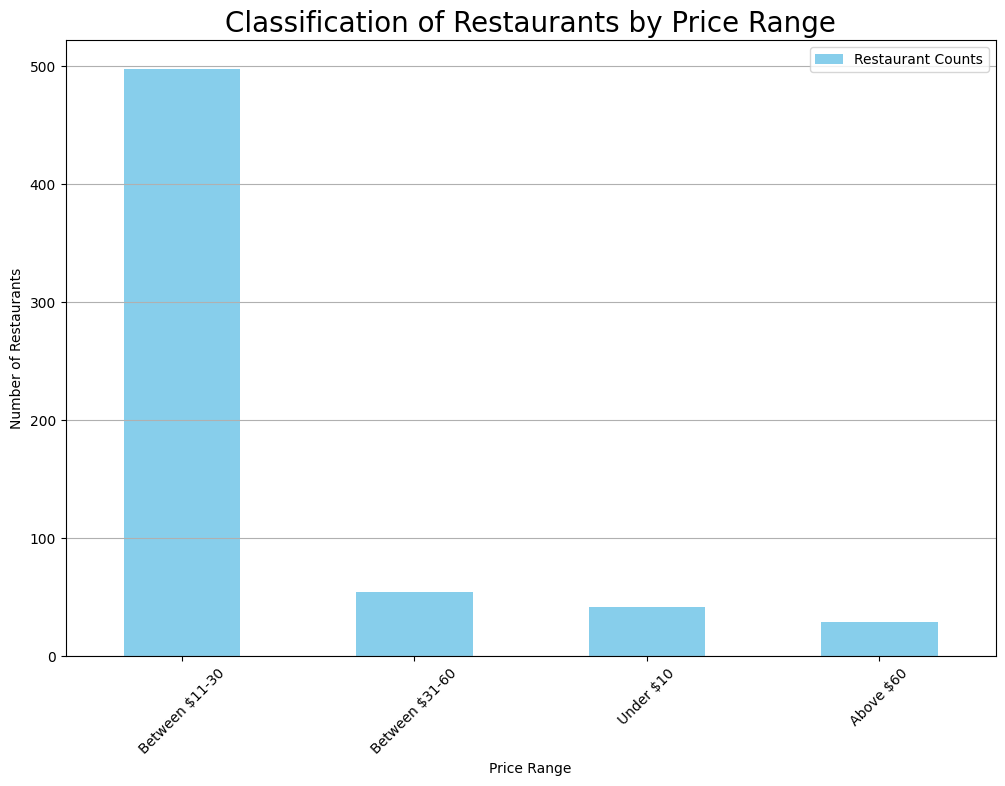

In [106]:
count_pricing = cleaned_data['price'].value_counts().rename_axis('Restaurant Price Range').reset_index(name='Restaurant Counts')
pricing_df = count_pricing.set_index('Restaurant Price Range')
pricing_df.rename(index={'$': 'Under $10', '$$': 'Between $11-30', '$$$': 'Between $31-60', '$$$$': 'Above $60'}, inplace=True)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(12, 8))
pricing_df.plot(kind='bar', ax=ax, color='skyblue')
plt.title('Classification of Restaurants by Price Range', fontsize=20)
plt.xlabel('Price Range')
plt.ylabel('Number of Restaurants')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

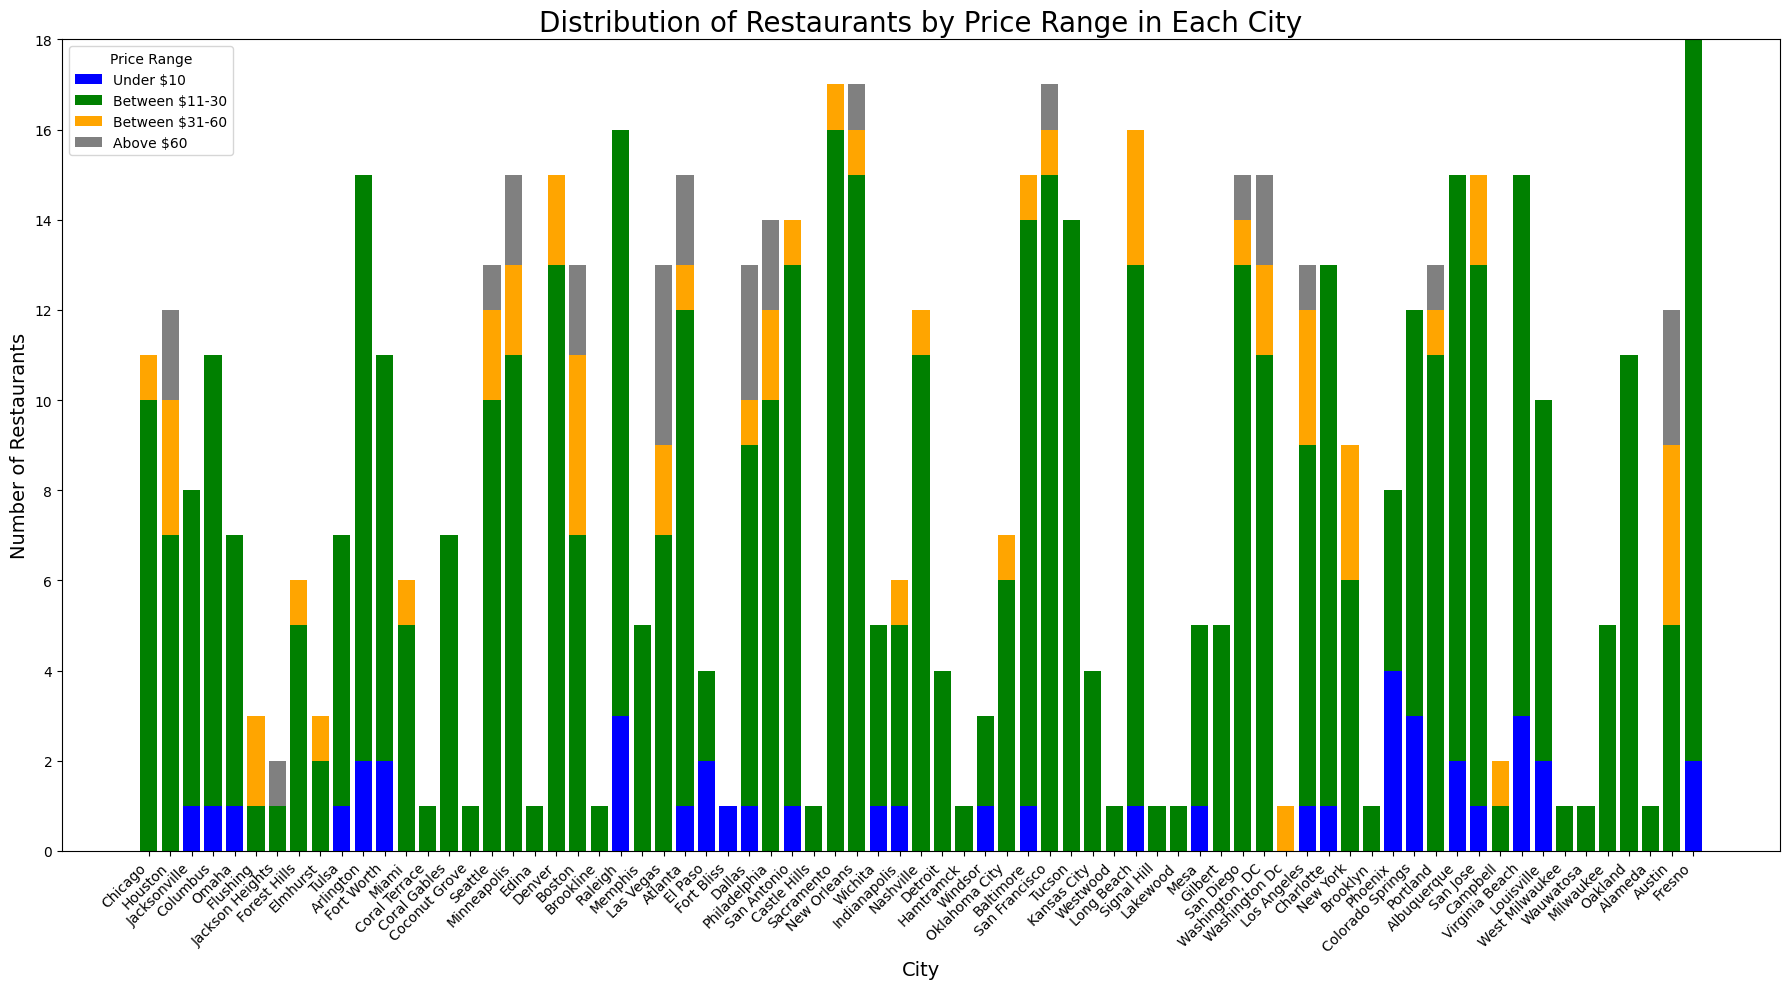

In [107]:
# Get unique cities
unique_cities = cleaned_data['city'].unique()

# Set up colors for each price range
colors = {'Under $10': 'blue', 'Between $11-30': 'green', 'Between $31-60': 'orange', 'Above $60': 'gray'}

# Initialize lists to store data for plotting
city_labels = []
price_ranges = {'Under $10': [], 'Between $11-30': [], 'Between $31-60': [], 'Above $60': []}

# Iterate over unique cities and collect data
for city in unique_cities:
    # Filter data for the current city
    city_data = cleaned_data[cleaned_data['city'] == city]
    
    # Value counts for price ranges and create a dataFrame
    count_pricing = city_data['price'].value_counts().rename_axis('Restaurant Price Range').reset_index(name='Restaurant Counts')
    pricing_df = count_pricing.set_index('Restaurant Price Range')
    pricing_df.rename(index={'$': 'Under $10', '$$': 'Between $11-30', '$$$': 'Between $31-60', '$$$$': 'Above $60'}, inplace=True)
    
    # Append city name to labels list
    city_labels.append(city)
    
    # Append counts for each price range to respective lists
    for price_range in price_ranges:
        if price_range in pricing_df.index:
            price_ranges[price_range].append(pricing_df.loc[price_range, 'Restaurant Counts'])
        else:
            price_ranges[price_range].append(0)

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(18, 10))  # Larger dimensions for the graph
bottom = None

for price_range, counts in price_ranges.items():
    ax.bar(city_labels, counts, label=price_range, color=colors[price_range], bottom=bottom)
    if bottom is None:
        bottom = counts
    else:
        bottom = [bottom[i] + counts[i] for i in range(len(bottom))]

plt.title('Distribution of Restaurants by Price Range in Each City', fontsize=20)
plt.xlabel('City', fontsize=14)
plt.ylabel('Number of Restaurants', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Price Range", loc="upper left")
plt.tight_layout()
plt.show()


#### Perform Regression and Correlation Analysis

In [110]:
merged_data = pd.merge(cleaned_data, income_data, on='city', how='left')

# Clean the 'Average HHI' column to remove '$' and commas and convert to numeric
merged_data['Average HHI'] = merged_data['Average HHI'].replace('[\$,]', '', regex=True).astype(float)

# Map the restaurant prices to numerical values
price_mapping = {
    '$': 10, '$$': 30, '$$$': 60, '$$$$': 100
}
merged_data['price_numeric'] = merged_data['price'].map(price_mapping)

# Calculate correlation coefficient between average household income and restaurant prices
merged_data.dropna(subset=['Average HHI', 'price_numeric'], inplace=True)
correlation, p_value = pearsonr(merged_data['Average HHI'], merged_data['price_numeric'])
print(f"Correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.5f}")

# Perform linear regression
X = sm.add_constant(merged_data['Average HHI'])
y = merged_data['price_numeric']
model = sm.OLS(y, X).fit()
print(model.summary())


Correlation coefficient: 0.03
P-value: 0.73457
                            OLS Regression Results                            
Dep. Variable:          price_numeric   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1154
Date:                Sun, 10 Mar 2024   Prob (F-statistic):              0.735
Time:                        14:12:06   Log-Likelihood:                -526.24
No. Observations:                 151   AIC:                             1056.
Df Residuals:                     149   BIC:                             1063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
con

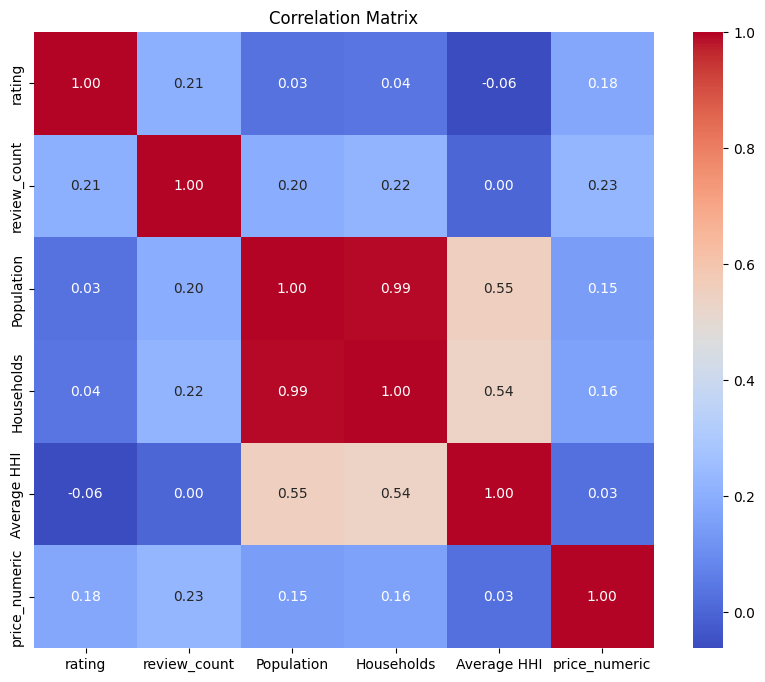

In [112]:
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()